# Southern Ocean bathymetry, sea ice, and fronts

In [1]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from cmocean import cm as cmo  
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import numpy as np
import cartopy.feature as cfeature
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

font = {'family' : 'Avenir',
        'weight' : 'normal',
        'size'   : 20}
mpl.rc('font', **font)

## Load the datasets

You must change the paths to the files

In [2]:
ice = xr.open_mfdataset('/Users/xedhjo/Documents/Projects/Sebs map/ASI-*gridded.nc').sic
bathy = xr.open_dataset('/Users/xedhjo/Documents/Projects/Sebs map/ETOPO1_Bed_g_gmt4.grd').z
adt = xr.open_dataset('/Users/xedhjo/Desktop/ssh_monthly_climatology_2004-2021.nc').adt

## Subset and interpolate the datasets to speed up plotting

In [3]:
bathy = bathy.sel(x=slice(-90,90),y=slice(-90,-20))
bathy = bathy.interp(y=np.arange(-90,-20,0.1),x=np.arange(-90,90,0.1)) # Once the map looks like you want, this can be commented out, and everything must be ran again, and it will take a bit longer to plot.
ice_snap = ice.sel(time='2020-01-01',lon=slice(-90,90))

## Plot the map

/Users/xedhjo/opt/miniconda3/envs/sbp/lib/python3.10/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/xedhjo/opt/miniconda3/envs/sbp/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/xedhjo/opt/miniconda3/envs/sbp/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


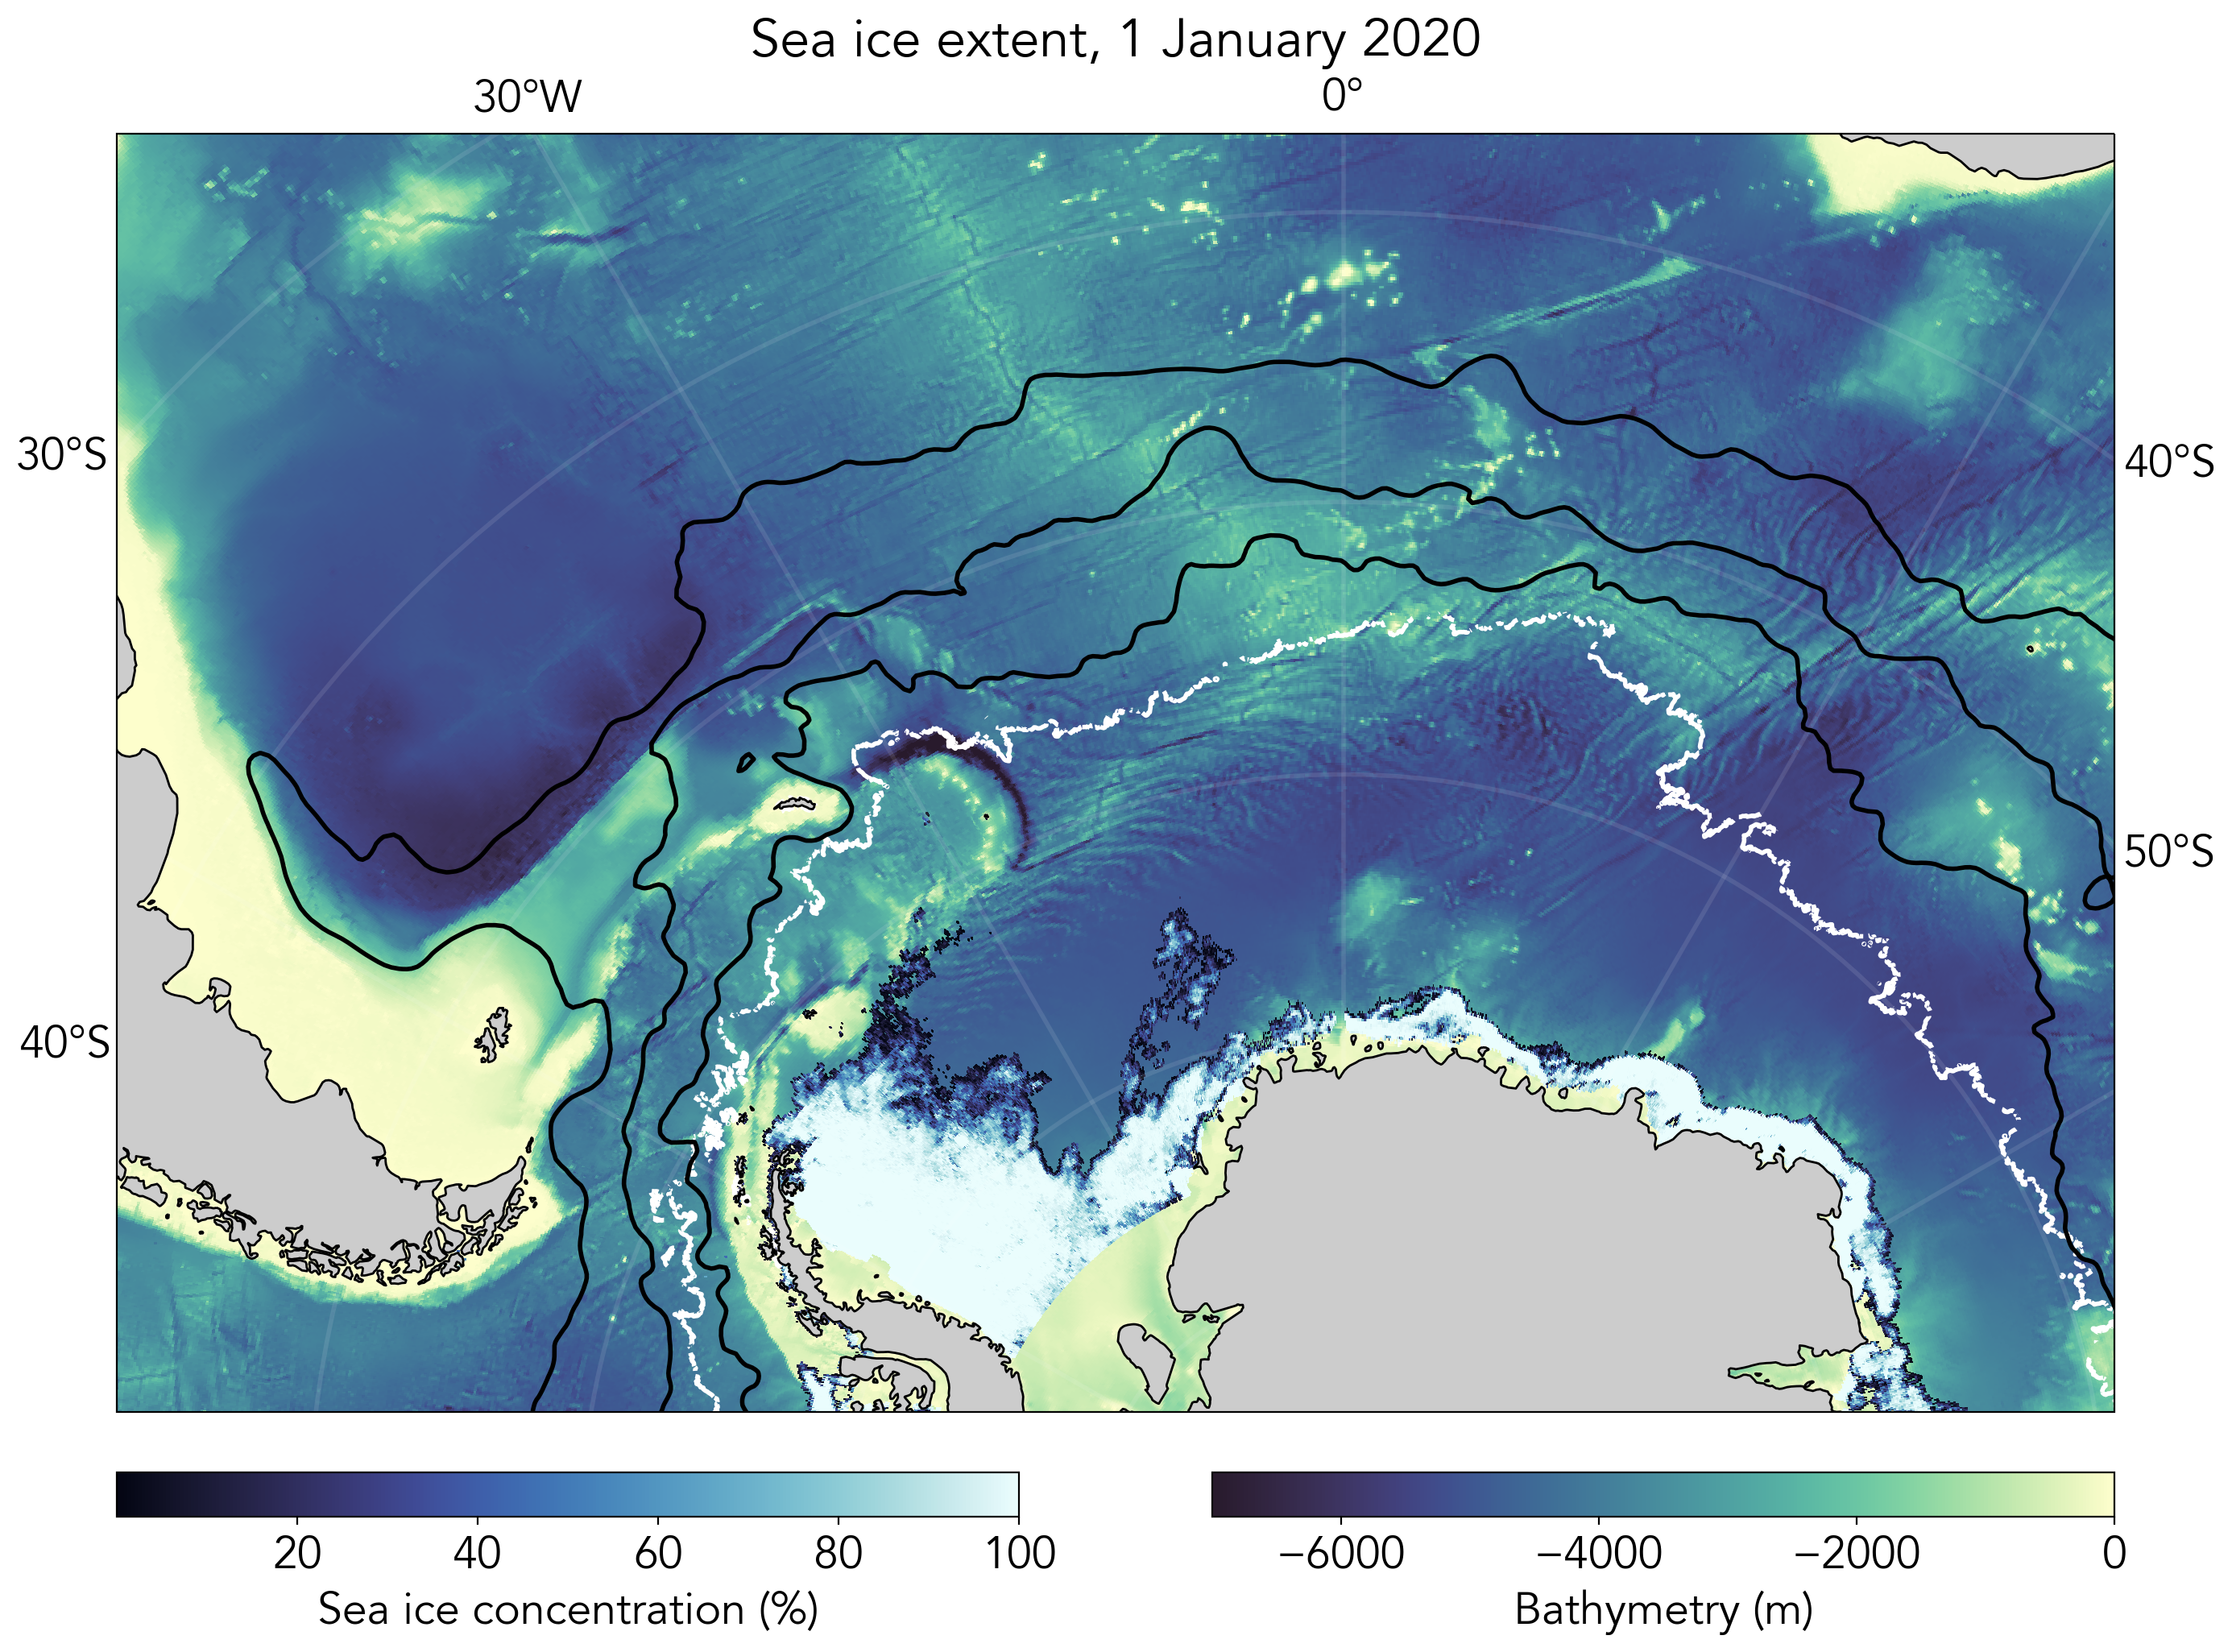

In [5]:
# Create a figure and axes to plot on, and define that we want a specific projection.
fig,ax = plt.subplots(1,1,figsize=(16,11),subplot_kw={'projection':ccrs.SouthPolarStereo()},dpi=200)

# Plot bathymetry
bath = bathy.plot(ax=ax,                        # Define which axes we will plot on
                  zorder=1,                     # Define the z-order, 1 means the first layer, 2 second layer etc. 
                  cmap=cmo.deep_r,              # Define the colormap
                  vmax=0,                       # Maximum value for the colorbar
                  vmin=-7000,                   # Minimum value for the colorbar
                  transform=ccrs.PlateCarree(), # Define which projection the data is in, a dataset where lat/lon acts like x/y will almost always be Plate Carree
                  add_colorbar=False)           # Do not create a colorbar, we will do this later

# Plot sea-ice concentration snapshot 
sic = ice_snap.plot(ax=ax,                           # See above
               zorder=2,
               cmap=cmo.ice,
               transform=ccrs.PlateCarree(),
               add_colorbar=False)

# Plot the average winter sea-ice extent for a given year, in this case July-August 2020. Exctent is se to 15% which is defined by the 'levels' argument.
sic2 = ice.sel(time=slice('2020-07-01','2020-09-01'),lon=slice(-90,90)).mean('time').plot.contour(ax=ax,
                                                                                                         zorder=2,
                                                                                                         transform=ccrs.PlateCarree(),
                                                                                                         levels=[15],
                                                                                                         linewidths=2,
                                                                                                         colors=['1'])

# Plot the fronts. ADT is averaged per month between 2004 and 2021, so you must decide which month that is accurate. Maybe we want to do a full mean, in that case, replace .sel(month=1) with .mean('month')
# Fronts are defined (levels) according to Kim and Orsi (2014). Colours are inverted due to negative values.
cs = adt.sel(month=7).plot.contour(levels=[-0.035, # SAF
                                           -0.61,  # PF
                                           -0.985], # SAACF
                                          # -1.14], # SBDY
                                   ax=ax,
                                   zorder=3,
                                   transform=ccrs.PlateCarree(),
                                   colors=[#"r",    # SBDY
                                           "k", # SACCF
                                           "k", # PF
                                           "k"],   # SAF
                                   linestyles='-',
                                   linewidths=2)

# Add axes for the colorbars at the bottom of the figure
cax = fig.add_axes([0.125, 0.075, 0.35, 0.025]) 
cbx = fig.add_axes([0.55, 0.075, 0.35, 0.025]) 

# Create the colorbars in said axes
cb1 = plt.colorbar(sic,**{'pad':0.01,'label':'Sea ice concentration (%)','orientation':'horizontal','aspect':50,'cax':cax})
cb2 = plt.colorbar(bath,**{'pad':0.01,'label':'Bathymetry (m)','orientation':'horizontal','aspect':50,'cax':cbx})

# Add land and coastline
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',color='0.8'),zorder=3)
ax.coastlines('50m',zorder=3)

# Define the map
ax.set_extent([-60, # Western boundary
                33, # Eastern boundary
               -80, # Southern boundary
               -37  # Northern boundary
              ],crs=ccrs.PlateCarree())
              

# Add gridlines and define some parameters
gl = ax.gridlines(crs=ccrs.PlateCarree(),
                  linewidth=2,
                  color='1', # Fraction of "gray", from black 0, to white 1. Can be any colour.
                  alpha=0.1,   # Sets the opacity for the lines
                  linestyle='-', 
                  draw_labels=True,
                  rotate_labels=0, # Define the rotation for the lat/lon labels, in this case none.
                  y_inline=False   # Draw the lat-labels on the outside of the plot.
                 )

gl.bottom_labels=False # These would be in the way of the colorbars
gl.top_labels=True # These would be in the way of the colorbars
gl.left_labels=True # These would be in the way of the colorbars
gl.right_labels=True # These would be in the way of the colorbars

gl.xformatter = LONGITUDE_FORMATTER # Adds the degree sign
gl.yformatter = LATITUDE_FORMATTER  # Adds the degree sign
gl.xlabel_style = {'color': 'k', 'weight': 'bold'}
gl.ylabel_style = {'color': 'k', 'weight': 'bold'}

# Add the title and push it up slightly, due to labels on the top
ax.set_title('Sea ice extent, 1 January 2020',y=1.05)

# Define z-order for the spines, aka frame, so that it's above the map features
for k, spine in ax.spines.items():  #ax.spines is a dictionary
    spine.set_zorder(12)
    
plt.savefig('southern_ocean_map.png') # Save the figure